In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import time
import requests

In [ ]:
# For reading stock data from yahoo
from pandas_datareader import DataReader

# For time stamps
from datetime import datetime

# For division
from __future__ import division

Getting Stock Symbol and Their Trailing P/E



In [ ]:
# Step 1: Fetch NIFTY 50 stock symbols dynamically with retry mechanism
def get_nifty50_symbols(max_retries=5):
    retries = 0
    while retries < max_retries:
        try:
            url = "https://archives.nseindia.com/content/indices/ind_nifty50list.csv"
            df = pd.read_csv(url)
            stock_symbols = df["Symbol"].tolist()
            return [symbol + ".NS" for symbol in stock_symbols]  # Append .NS for Yahoo Finance
        except requests.exceptions.RequestException as e:
            print(f"Error fetching NIFTY 50 list: {e}")
            retries += 1
            time.sleep(5)  # Retry after 5 seconds
    return []

# Step 2: Fetch P/E ratios for all NIFTY 50 stocks
def get_pe_ratios(stock_list):
    pe_data = []
    for stock in stock_list:
        try:
            ticker = yf.Ticker(stock)
            pe_trailing = ticker.info.get("trailingPE", None)
            if pe_trailing is not None:
                pe_data.append({"Symbol": stock, "Trailing P/E": pe_trailing})
            else:
                print(f"Skipping {stock} due to missing P/E ratio.")
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")
            time.sleep(5)  # Delay to avoid hitting rate limits
            continue
    return pe_data

# Step 3: Run the process
nifty50_symbols = get_nifty50_symbols()
if not nifty50_symbols:
    print("Could not fetch NIFTY 50 list after multiple retries. Exiting.")
else:
    pe_ratios = get_pe_ratios(nifty50_symbols)

    # Step 4: Save the data to a CSV
    if pe_ratios:
        df_pe_ratios = pd.DataFrame(pe_ratios)
        df_pe_ratios.to_csv("nifty50_pe_ratios.csv", index=False)
        print("P/E ratios saved to 'nifty50_pe_ratios.csv'")
    else:
        print("No valid P/E ratios found.")

P/E ratios saved to 'nifty50_pe_ratios.csv'


Industry Name, Avg P/E, Min P/E, Max P/E, Std Dev P/E, Stocks Count

In [ ]:
# Step 1: Fetch NIFTY 50 stock symbols dynamically with retry mechanism
def get_nifty50_symbols(max_retries=5):
    retries = 0
    while retries < max_retries:
        try:
            url = "https://archives.nseindia.com/content/indices/ind_nifty50list.csv"
            df = pd.read_csv(url)
            stock_symbols = df["Symbol"].tolist()
            return [symbol + ".NS" for symbol in stock_symbols]  # Append .NS for Yahoo Finance
        except requests.exceptions.RequestException as e:
            print(f"Error fetching NIFTY 50 list: {e}")
            retries += 1
            time.sleep(5)  # Retry after 5 seconds
    return []

# Step 2: Fetch Industry Information and P/E Ratios for NIFTY 50 Stocks
def get_industry_pe_data(stock_list):
    industry_data = {}

    for stock in stock_list:
        try:
            ticker = yf.Ticker(stock)
            info = ticker.info

            industry = info.get("industry", "Unknown")
            pe_trailing = info.get("trailingPE", None)

            if pe_trailing is not None:
                if industry not in industry_data:
                    industry_data[industry] = []
                industry_data[industry].append(pe_trailing)

            time.sleep(1)  # Avoid hitting API rate limits
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")

    return industry_data

# Step 3: Compute Industry-wise P/E Statistics
def compute_industry_pe_statistics(industry_data):
    industry_list = []
    for industry, pe_values in industry_data.items():
        industry_list.append({
            "Industry": industry,
            "Avg P/E": round(sum(pe_values) / len(pe_values), 2),
            "Min P/E": round(min(pe_values), 2),
            "Max P/E": round(max(pe_values), 2),
            "Std Dev P/E": round(pd.Series(pe_values).std(), 2),
            "Stocks Count": len(pe_values)
        })

    return pd.DataFrame(industry_list)

# Step 4: Run the Process for NIFTY 50
nifty50_symbols = get_nifty50_symbols()
if not nifty50_symbols:
    print("Could not fetch NIFTY 50 list. Exiting.")
else:
    industry_pe_data = get_industry_pe_data(nifty50_symbols)
    industry_df = compute_industry_pe_statistics(industry_pe_data)

    # Step 5: Save the Data in a CSV
    output_file = "nifty50_industry_pe_analysis.csv"
    industry_df.to_csv(output_file, index=False)

    print(f"✅ Industry-wise P/E analysis saved as {output_file}")
    print(industry_df.sort_values(by="Avg P/E", ascending=False).head(10))  # Show top 10 highest P/E industries

✅ Industry-wise P/E analysis saved as nifty50_industry_pe_analysis.csv
                         Industry  Avg P/E  Min P/E  Max P/E  Std Dev P/E  \
11                Internet Retail   308.15   308.15   308.15          NaN   
19               Asset Management   101.83   101.83   101.83          NaN   
26                 Apparel Retail    99.51    99.51    99.51          NaN   
25                   Luxury Goods    92.84    92.84    92.84          NaN   
22                 Packaged Foods    80.74    71.91    89.57        12.49   
14               Insurance - Life    78.46    71.70    85.23         9.57   
2         Medical Care Facilities    76.94    76.94    76.94          NaN   
18                          Steel    70.22    63.74    76.71         9.17   
3             Specialty Chemicals    55.53    55.53    55.53          NaN   
16  Household & Personal Products    51.35    51.35    51.35          NaN   

    Stocks Count  
11             1  
19             1  
26             1  
25   

Stocks segregated by industry

In [ ]:
# Load the CSV containing stocks and P/E ratios
file_path = "nifty50_pe_ratios.csv"
df = pd.read_csv(file_path)

# Load the industry names from the 'industry_pe_analysis.csv' file (assuming industry names are in the first column)
industry_file_path = "nifty50_industry_pe_analysis.csv"
industry_df = pd.read_csv(industry_file_path)

# Extract the industry names from the first column of the industry CSV
allowed_industries = industry_df.iloc[:, 0].tolist()

# Dictionary to store industry-wise stocks
industry_data = {}

# Step 1: Fetch Industry Information for Each Stock
for stock in df["Symbol"]:
    try:
        ticker = yf.Ticker(stock)
        industry = ticker.info.get("industry", "Unknown")

        # Only consider industries in the allowed list
        if industry in allowed_industries:
            pe_value = df.loc[df["Symbol"] == stock, "Trailing P/E"].values[0]

            if industry not in industry_data:
                industry_data[industry] = []
            industry_data[industry].append({"Symbol": stock, "Trailing P/E": pe_value})

        time.sleep(1)  # Avoid API rate limits
    except Exception as e:
        print(f"Error fetching industry for {stock}: {e}")

# Step 2: Convert Industry Data to DataFrame
industry_list = []
for industry, stocks in industry_data.items():
    for stock in stocks:
        industry_list.append({
            "Industry": industry,
            "Symbol": stock["Symbol"],
            "Trailing P/E": stock["Trailing P/E"]
        })

# Step 3: Save the Data to a CSV
output_file = "nifty50_stocks_by_industry.csv"
industry_df = pd.DataFrame(industry_list)
industry_df.to_csv(output_file, index=False)

print(f"✅ Stocks segregated by industry and saved as {output_file}")

✅ Stocks segregated by industry and saved as nifty50_stocks_by_industry.csv


------------------------ Analysis ------------------------

Thumb Rule

- ✅ P/E < 10 → Undervalued (May be cheap, but check for risks like declining business).
- ✅ P/E 10-25 → Fairly Valued (Within the normal range for most industries).
- ✅ P/E 25-40 → Fairly Valued (Acceptable for high-growth companies).
- ✅ P/E > 50 → Overvalued (Risky unless backed by strong growth).

In [ ]:
# Load the CSV containing NIFTY 50 stocks and their P/E ratios
file_path = "nifty50_pe_ratios.csv"
df = pd.read_csv(file_path)

# Ensure P/E values are numeric (handle any missing or invalid values)
df["Trailing P/E"] = pd.to_numeric(df["Trailing P/E"], errors="coerce")

# Drop rows where P/E is NaN (missing values)
df = df.dropna(subset=["Trailing P/E"])

# Function to classify stocks based on P/E ratio
def classify_pe(pe):
    if pe < 10:
        return "Undervalued"
    elif 10 <= pe <= 40:  # Combining both normal & high-growth ranges into "Fairly Valued"
        return "Fairly Valued"
    else:  # P/E > 50
        return "Overvalued"

# Apply classification function to each stock
df["Valuation"] = df["Trailing P/E"].apply(classify_pe)

# Save the classified data to a new CSV
output_file = "nifty50_pe_valuation_thumbrule.csv"
df.to_csv(output_file, index=False)

# Print summary results
print(f"✅ NIFTY 50 P/E valuation completed and saved as {output_file}")
print("\n🔍 First 5 Rows of Classified Data:")
print(df.head(5))  # Display first 5 rows

✅ NIFTY 50 P/E valuation completed and saved as nifty50_pe_valuation_thumbrule.csv

🔍 First 5 Rows of Classified Data:
          Symbol  Trailing P/E      Valuation
0    ADANIENT.NS     78.050900     Overvalued
1  ADANIPORTS.NS     25.980350  Fairly Valued
2  APOLLOHOSP.NS     76.942120     Overvalued
3  ASIANPAINT.NS     55.530136     Overvalued
4    AXISBANK.NS     13.165891  Fairly Valued


Stocks valuation analysis using The Range of Upper and Lower
- Overvalued, Fairly Valued and Undervalued

In [ ]:
# Load the CSV containing NIFTY 50 stocks and their P/E ratios by industry
file_path = "nifty50_stocks_by_industry.csv"
df = pd.read_csv(file_path)

# Load the industry analysis CSV for NIFTY 50
industry_file_path = "nifty50_industry_pe_analysis.csv"
industry_df = pd.read_csv(industry_file_path)

# Create a dictionary to store industry details for comparison
industry_data = {}

# Step 1: Load industry data into a dictionary for easy lookup
for _, row in industry_df.iterrows():
    avg_pe = row['Avg P/E']
    std_dev_pe = row['Std Dev P/E']

    # Handle NaN values in Std Dev P/E
    if pd.isna(std_dev_pe) or std_dev_pe == 0:
        std_dev_pe = max(0.1 * avg_pe, 1)  # Use 10% of Avg P/E or at least 1

    industry_data[row['Industry']] = {
        'Avg P/E': avg_pe,
        'Min P/E': row['Min P/E'],
        'Max P/E': row['Max P/E'],
        'Std Dev P/E': std_dev_pe,
        'Stocks Count': row['Stocks Count']
    }

# Dictionary to store the analysis of stocks in each industry
industry_analysis = []

# Step 2: Process each stock's P/E ratio and compare with industry P/E
for _, stock_row in df.iterrows():
    symbol = stock_row['Symbol']
    stock_pe = stock_row['Trailing P/E']
    industry = stock_row['Industry']  # Directly get the industry from the stock row

    if industry in industry_data:
        # Get the industry details
        avg_pe = industry_data[industry]['Avg P/E']
        min_pe = industry_data[industry]['Min P/E']
        max_pe = industry_data[industry]['Max P/E']
        std_dev_pe = industry_data[industry]['Std Dev P/E']

        # Define the acceptable P/E range with improved calculations
        lower_bound = max(avg_pe - std_dev_pe, 0)  # Ensure lower bound is not negative
        upper_bound = min(avg_pe + std_dev_pe, avg_pe * 2)  # Cap the upper bound

        # Determine if the stock is undervalued, fairly valued, or overvalued
        if stock_pe < lower_bound:
            valuation = "Undervalued"
        elif stock_pe > upper_bound:
            valuation = "Overvalued"
        else:
            valuation = "Fairly Valued"

        # Add the analysis for this stock
        industry_analysis.append({
            "Industry": industry,
            "Symbol": symbol,
            "Trailing P/E": stock_pe,
            "Avg P/E (Industry)": avg_pe,
            "Min P/E (Industry)": min_pe,
            "Max P/E (Industry)": max_pe,
            "Std Dev P/E (Industry)": std_dev_pe,
            "Lower Bound": lower_bound,
            "Upper Bound": upper_bound,
            "Valuation": valuation
        })

# Step 3: Convert industry analysis to a DataFrame
analysis_df = pd.DataFrame(industry_analysis)

# Step 4: Save the Data to a CSV
output_file = "nifty50_stocks_valuation_range_analysis.csv"
analysis_df.to_csv(output_file, index=False)

# Step 5: Print the first 5 rows of the analysis
print(f"✅ Stocks valuation analysis complete and saved as {output_file}")
print("\n🔍 First 5 Rows of Valuation Analysis:")
print(analysis_df.head(5))  # Display first 5 rows

✅ Stocks valuation analysis complete and saved as nifty50_stocks_valuation_range_analysis.csv

🔍 First 5 Rows of Valuation Analysis:
                  Industry         Symbol  Trailing P/E  Avg P/E (Industry)  \
0             Thermal Coal    ADANIENT.NS     78.050900               42.52   
1             Thermal Coal   COALINDIA.NS      6.988147               42.52   
2          Marine Shipping  ADANIPORTS.NS     25.980350               25.98   
3  Medical Care Facilities  APOLLOHOSP.NS     76.942120               76.94   
4      Specialty Chemicals  ASIANPAINT.NS     55.530136               55.53   

   Min P/E (Industry)  Max P/E (Industry)  Std Dev P/E (Industry)  \
0                6.99               78.05                  50.250   
1                6.99               78.05                  50.250   
2               25.98               25.98                   2.598   
3               76.94               76.94                   7.694   
4               55.53               55.53      

Matching both the Output to see the common Taking 3 months price change

In [ ]:
# Load both valuation analysis files
thumbrule_file = "nifty50_pe_valuation_thumbrule.csv"
range_analysis_file = "nifty50_stocks_valuation_range_analysis.csv"

df_thumbrule = pd.read_csv(thumbrule_file)
df_range = pd.read_csv(range_analysis_file)

# Rename valuation columns for clarity
df_thumbrule = df_thumbrule.rename(columns={"Valuation": "Valuation_Thumbrule"})
df_range = df_range.rename(columns={"Valuation": "Valuation_Range"})

# Merge both datasets on Symbol
merged_df = pd.merge(df_thumbrule, df_range, on="Symbol", how="inner")

# Ensure stock symbols are correctly formatted for Yahoo Finance
def format_symbol(symbol):
    if not symbol.endswith(".NS"):
        return symbol + ".NS"
    return symbol

merged_df["Yahoo_Symbol"] = merged_df["Symbol"].apply(format_symbol)

# Function to fetch stock price change from Yahoo Finance
def get_stock_price_change(symbol, period="3mo"):
    try:
        stock = yf.Ticker(symbol)
        history = stock.history(period=period)

        if len(history) < 2:
            return None  # Not enough data

        start_price = history["Close"].iloc[0]  # First available price
        end_price = history["Close"].iloc[-1]   # Latest price

        price_change = ((end_price - start_price) / start_price) * 100  # % Change
        return round(price_change, 2)
    except Exception:
        return None  # Handle errors silently

# Fetch price change data for all stocks
merged_df["3M Price Change (%)"] = merged_df["Yahoo_Symbol"].apply(lambda x: get_stock_price_change(x, period="3mo"))

# Remove stocks where data is missing
merged_df = merged_df.dropna(subset=["3M Price Change (%)"])

# Step 1: Calculate average returns for each valuation category
thumbrule_performance = merged_df.groupby("Valuation_Thumbrule")["3M Price Change (%)"].mean()
range_performance = merged_df.groupby("Valuation_Range")["3M Price Change (%)"].mean()

# Step 2: Compare which method aligns better
print("\n📊 **Performance Based on Price Changes**:")
print("\n🔹 **Thumb Rule Method Performance:**")
print(thumbrule_performance)
print("\n🔹 **Range-Based Method Performance:**")
print(range_performance)

# Save results to a CSV
output_file = "nifty50_valuation_performance.csv"
merged_df.to_csv(output_file, index=False)
print(f"\n📊 **Detailed performance report saved as {output_file}**")


📊 **Performance Based on Price Changes**:

🔹 **Thumb Rule Method Performance:**
Valuation_Thumbrule
Fairly Valued    3.021154
Overvalued       8.736111
Undervalued     -0.975000
Name: 3M Price Change (%), dtype: float64

🔹 **Range-Based Method Performance:**
Valuation_Range
Fairly Valued    6.223023
Overvalued       0.420000
Undervalued     -9.725000
Name: 3M Price Change (%), dtype: float64

📊 **Detailed performance report saved as nifty50_valuation_performance.csv**


In [ ]:
# Load the two valuation CSVs
thumb_rule_file = "nifty50_pe_valuation_thumbrule.csv"
range_based_file = "nifty50_stocks_valuation_range_analysis.csv"
performance_file = "nifty50_valuation_performance.csv"

# Read the data
thumb_df = pd.read_csv(thumb_rule_file)
range_df = pd.read_csv(range_based_file)
performance_df = pd.read_csv(performance_file)

# Merge the valuation data using stock symbols
merged_df = thumb_df.merge(range_df, on="Symbol", suffixes=("_Thumbrule", "_Range"))
merged_df = merged_df.merge(performance_df[['Symbol', '3M Price Change (%)']], on="Symbol", how="left")

# Define a final consensus valuation based on both methods
def determine_final_valuation(row):
    if row["Valuation_Thumbrule"] == row["Valuation_Range"]:
        return row["Valuation_Thumbrule"]  # If both methods agree, take that value
    else:
        return "Overvalued"  # If there's disagreement, flag it for further analysis

# Apply the function to determine the final valuation
merged_df["Final Valuation"] = merged_df.apply(determine_final_valuation, axis=1)

# Select the required columns for the final output
final_output = merged_df[["Symbol", "Valuation_Thumbrule", "Valuation_Range", "Final Valuation", "3M Price Change (%)"]]

# Save the final output to a CSV
output_file = "nifty50_final_stock_valuation.csv"
final_output.to_csv(output_file, index=False)

# Print confirmation
print(f"✅ Final stock valuation analysis saved as {output_file}")
print("\n🔍 Sample of the final output:")
print(final_output.head(10))  # Show first 10 rows

✅ Final stock valuation analysis saved as nifty50_final_stock_valuation.csv

🔍 Sample of the final output:
          Symbol Valuation_Thumbrule Valuation_Range Final Valuation  \
0    ADANIENT.NS          Overvalued   Fairly Valued      Overvalued   
1  ADANIPORTS.NS       Fairly Valued   Fairly Valued   Fairly Valued   
2  APOLLOHOSP.NS          Overvalued   Fairly Valued      Overvalued   
3  ASIANPAINT.NS          Overvalued   Fairly Valued      Overvalued   
4    AXISBANK.NS       Fairly Valued   Fairly Valued   Fairly Valued   
5  BAJAJ-AUTO.NS       Fairly Valued   Fairly Valued   Fairly Valued   
6  BAJFINANCE.NS       Fairly Valued   Fairly Valued   Fairly Valued   
7  BAJAJFINSV.NS       Fairly Valued   Fairly Valued   Fairly Valued   
8         BEL.NS          Overvalued   Fairly Valued      Overvalued   
9  BHARTIARTL.NS          Overvalued   Fairly Valued      Overvalued   

   3M Price Change (%)  
0                 0.52  
1                10.89  
2                 3.21  


Based on the Overvalued Valuation.. We perfrom CAPM..

In [ ]:
# Load stock valuation data
valuation_file = "nifty50_final_stock_valuation.csv"
valuation_df = pd.read_csv(valuation_file)

# Load historical market returns data
market_file = "nifty50_historical_return.csv"
market_df = pd.read_csv(market_file)

# Load stock-to-industry mapping
industry_file = "nifty50_stocks_by_industry.csv"
industry_df = pd.read_csv(industry_file)

# Calculate Market Return (Rm) as the average of the Annual column
Rm = market_df['Annual'].mean() / 100  # Convert percentage to decimal
print(f"📈 Calculated Market Return (Rm): {Rm:.4f} ({Rm*100:.2f}%)")

# Define Risk-Free Rate (Rf) - India 10Y Govt Bond Yield
Rf = 0.0658  # 6.58%

# Filter stocks that are Overvalued in Final Valuation
overvalued_stocks = valuation_df[valuation_df['Final Valuation'] == "Overvalued"]

# Merge with industry data to get industry names
overvalued_stocks = overvalued_stocks.merge(industry_df, on="Symbol", how="left")

# Dictionary to store industry-level beta values
industry_betas = {}

# Fetch beta values for each stock
for symbol in overvalued_stocks['Symbol']:
    try:
        ticker = yf.Ticker(symbol)
        beta = ticker.info.get('beta', None)

        if beta is not None:
            industry = overvalued_stocks.loc[overvalued_stocks['Symbol'] == symbol, 'Industry'].values[0]
            if industry not in industry_betas:
                industry_betas[industry] = []
            industry_betas[industry].append(beta)
    except Exception as e:
        print(f"Error fetching beta for {symbol}: {e}")

# Compute average beta for each industry
for industry, betas in industry_betas.items():
    industry_betas[industry] = sum(betas) / len(betas) if betas else 1.0  # Default to 1.0 if missing

# Store CAPM results
capm_results = []

# Process each overvalued stock
for index, row in overvalued_stocks.iterrows():
    symbol = row['Symbol']
    industry = row['Industry']

    # Fetch the stock's beta from Yahoo Finance
    try:
        ticker = yf.Ticker(symbol)
        beta = ticker.info.get('beta', None)

        # If beta is missing, use industry beta
        if beta is None:
            if industry in industry_betas:
                beta = industry_betas[industry]  # Use industry average beta
                print(f"⚠️ Warning: Missing beta for {symbol}. Using industry average beta ({industry}) = {beta:.2f}")
            else:
                beta = 1.0  # Default market beta if no industry beta is available
                print(f"⚠️ Warning: Missing beta for {symbol} and industry {industry}. Using default beta = 1.0")

        # Compute Expected Return using CAPM formula
        Re = Rf + beta * (Rm - Rf)

        # Append data to results list
        capm_results.append({
            'Symbol': symbol,
            'Industry': industry,
            'Beta': beta,
            'Expected Return (Re)': Re * 100  # Convert to percentage
        })

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Convert results to a DataFrame
capm_df = pd.DataFrame(capm_results)

# Print CAPM results
print("\n📊 CAPM Analysis for Overvalued Stocks:")
print(capm_df.head(10))  # Display first 10 rows

# Save the results to a CSV
capm_df.to_csv("overvalued_stocks_capm.csv", index=False)

print("\n✅ CAPM analysis completed and saved as 'overvalued_stocks_capm.csv'")

📈 Calculated Market Return (Rm): 0.1533 (15.33%)
⚠️ Warning: Missing beta for JIOFIN.NS and industry Asset Management. Using default beta = 1.0

📊 CAPM Analysis for Overvalued Stocks:
          Symbol                 Industry   Beta  Expected Return (Re)
0    ADANIENT.NS             Thermal Coal  0.664             12.393187
1  APOLLOHOSP.NS  Medical Care Facilities  0.372              9.836786
2  ASIANPAINT.NS      Specialty Chemicals  0.389              9.985617
3         BEL.NS      Aerospace & Defense  0.376              9.871805
4  BHARTIARTL.NS         Telecom Services  0.194              8.278431
5   COALINDIA.NS             Thermal Coal  0.015              6.711322
6   EICHERMOT.NS       Auto Manufacturers  0.286              9.083873
7     ETERNAL.NS          Internet Retail  0.252              8.786210
8      GRASIM.NS       Building Materials  0.272              8.961306
9    HDFCLIFE.NS         Insurance - Life  0.741             13.067307

✅ CAPM analysis completed and save

In [ ]:
# Load the CAPM results
capm_file = "overvalued_stocks_capm.csv"
capm_df = pd.read_csv(capm_file)

# Load the final stock valuation file (which contains 3M Price Change %)
valuation_file = "nifty50_final_stock_valuation.csv"
valuation_df = pd.read_csv(valuation_file)

# Merge CAPM data with valuation data based on Symbol
merged_df = pd.merge(capm_df, valuation_df[['Symbol', '3M Price Change (%)']], on="Symbol", how="left")

# Convert '3M Price Change (%)' to numeric and handle errors
merged_df['3M Price Change (%)'] = pd.to_numeric(merged_df['3M Price Change (%)'], errors='coerce')

# Define a function to compare Expected Return with 3M Price Change
def compare_returns(row):
    expected_return = row['Expected Return (Re)']
    actual_return = row['3M Price Change (%)']

    if pd.isna(actual_return):  # If 3M Price Change data is missing
        return "Data Missing"

    if abs(expected_return - actual_return) <= 1:  # Tolerance of ±1%
        return "Matched CAPM"
    elif expected_return > actual_return:
        return "Underperformed"
    else:
        return "Outperformed"

# Apply the function to determine performance
merged_df['CAPM Performance'] = merged_df.apply(compare_returns, axis=1)

# Save the results to a CSV file
output_file = "capm_vs_price_change.csv"
merged_df.to_csv(output_file, index=False)

# Display results
print("\n📊 CAPM Performance Analysis:")
print(merged_df[['Symbol', 'Expected Return (Re)', '3M Price Change (%)', 'CAPM Performance']].head(10))
print(f"\n✅ Analysis saved as '{output_file}'")


📊 CAPM Performance Analysis:
          Symbol  Expected Return (Re)  3M Price Change (%) CAPM Performance
0    ADANIENT.NS             12.393187                 0.52   Underperformed
1  APOLLOHOSP.NS              9.836786                 3.21   Underperformed
2  ASIANPAINT.NS              9.985617                10.25     Matched CAPM
3         BEL.NS              9.871805                19.33     Outperformed
4  BHARTIARTL.NS              8.278431                13.96     Outperformed
5   COALINDIA.NS              6.711322                 4.06   Underperformed
6   EICHERMOT.NS              9.083873                 7.64   Underperformed
7     ETERNAL.NS              8.786210                10.25     Outperformed
8      GRASIM.NS              8.961306                11.90     Outperformed
9    HDFCLIFE.NS             13.067307                13.80     Matched CAPM

✅ Analysis saved as 'capm_vs_price_change.csv'


In [ ]:
# Load stock valuation data
valuation_file = "nifty50_final_stock_valuation.csv"
valuation_df = pd.read_csv(valuation_file)

# Filter only Overvalued stocks
overvalued_stocks = valuation_df[valuation_df["Final Valuation"] == "Overvalued"]

# Load CAPM vs. 3M Price Change data
capm_performance_file = "capm_vs_price_change.csv"
capm_df = pd.read_csv(capm_performance_file)

# Merge Overvalued stocks with CAPM Performance based on Symbol
comparison_df = overvalued_stocks.merge(capm_df[['Symbol', 'CAPM Performance']], on="Symbol", how="inner")

# Keep only required columns
final_df = comparison_df[['Symbol', 'Final Valuation', 'CAPM Performance']]

# Save the cleaned data to CSV
output_file = "overvalued_stocks_final_performance.csv"
final_df.to_csv(output_file, index=False)

# Display sample output
print("\n📊 Overvalued Stocks - Final Performance Data:")
print(final_df.head(10))

print(f"\n✅ Cleaned comparison saved as '{output_file}'")


📊 Overvalued Stocks - Final Performance Data:
          Symbol Final Valuation CAPM Performance
0    ADANIENT.NS      Overvalued   Underperformed
1  APOLLOHOSP.NS      Overvalued   Underperformed
2  ASIANPAINT.NS      Overvalued     Matched CAPM
3         BEL.NS      Overvalued     Outperformed
4  BHARTIARTL.NS      Overvalued     Outperformed
5   COALINDIA.NS      Overvalued   Underperformed
6   EICHERMOT.NS      Overvalued   Underperformed
7     ETERNAL.NS      Overvalued     Outperformed
8      GRASIM.NS      Overvalued     Outperformed
9    HDFCLIFE.NS      Overvalued     Matched CAPM

✅ Cleaned comparison saved as 'overvalued_stocks_final_performance.csv'


In [ ]:
import pandas as pd

# Load the cleaned Overvalued Stocks Performance data
file_path = "overvalued_stocks_final_performance.csv"
df = pd.read_csv(file_path)

# Filter stocks that are both Overvalued and Underperformed
underperforming_overvalued = df[
    (df["Final Valuation"] == "Overvalued") &
    (df["CAPM Performance"] == "Underperformed")
]

# Extract symbols
stock_symbols = underperforming_overvalued["Symbol"].tolist()

# Save the filtered DataFrame to a CSV file
output_file = "underperforming_overvalued_stocks.csv"
underperforming_overvalued.to_csv(output_file, index=False)

# Print result
if stock_symbols:
    print("\n📉 The stocks that are both Overvalued and also Underperformed are:")
    print(", ".join(stock_symbols))
    print(f"\n✅ Stock names saved to '{output_file}'")
else:
    print("\n✅ No Overvalued stocks Underperformed.")


📉 The stocks that are both Overvalued and also Underperformed are:
ADANIENT.NS, APOLLOHOSP.NS, COALINDIA.NS, EICHERMOT.NS, HINDALCO.NS, HINDUNILVR.NS, JSWSTEEL.NS, JIOFIN.NS, ONGC.NS, SUNPHARMA.NS, TATASTEEL.NS, TECHM.NS, TITAN.NS, TRENT.NS, ULTRACEMCO.NS, WIPRO.NS

✅ Stock names saved to 'underperforming_overvalued_stocks.csv'


[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


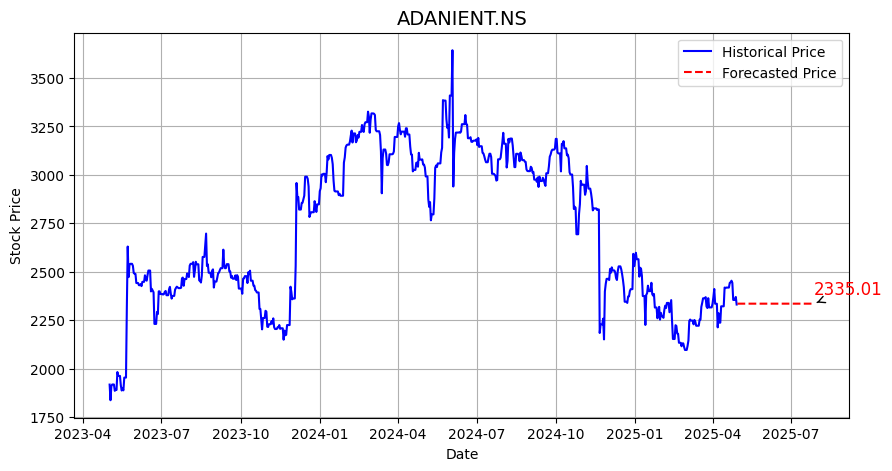

[*********************100%***********************]  1 of 1 completed


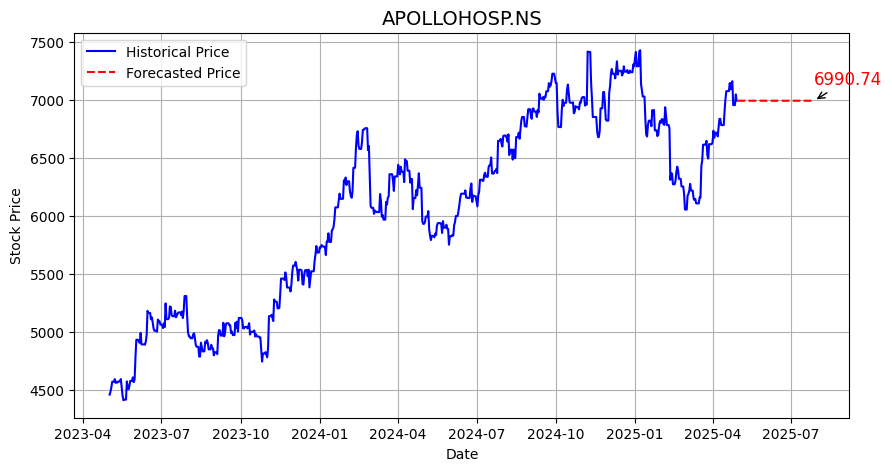

[*********************100%***********************]  1 of 1 completed


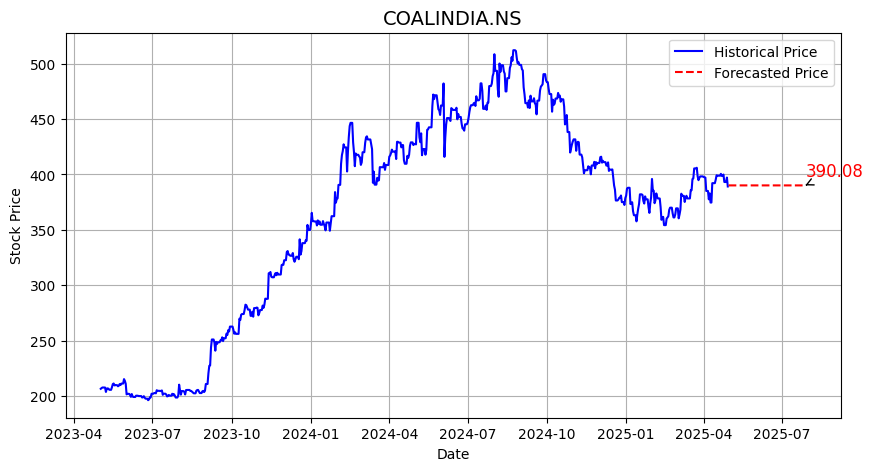

[*********************100%***********************]  1 of 1 completed


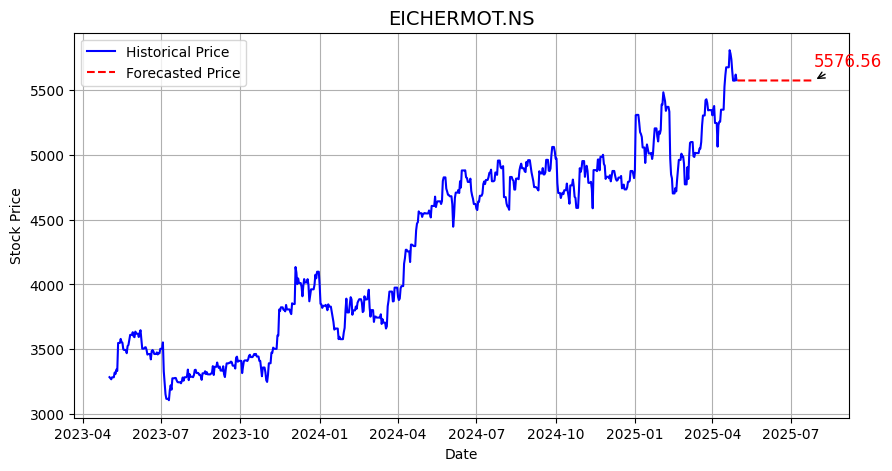

[*********************100%***********************]  1 of 1 completed


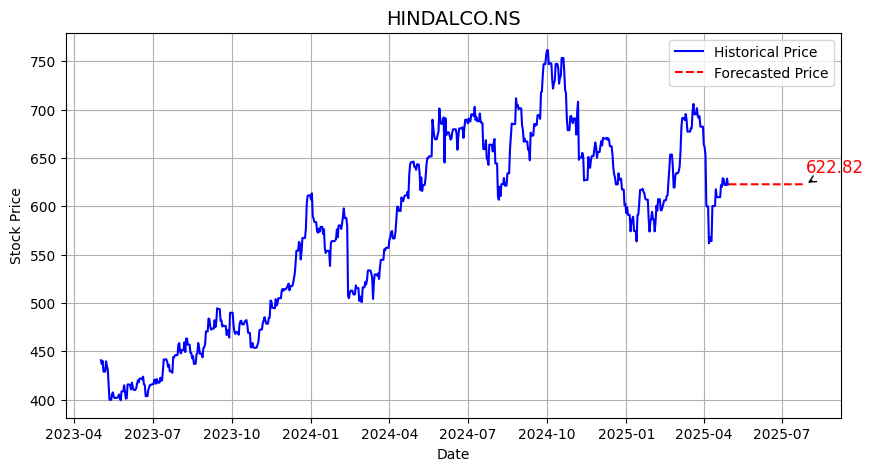

[*********************100%***********************]  1 of 1 completed


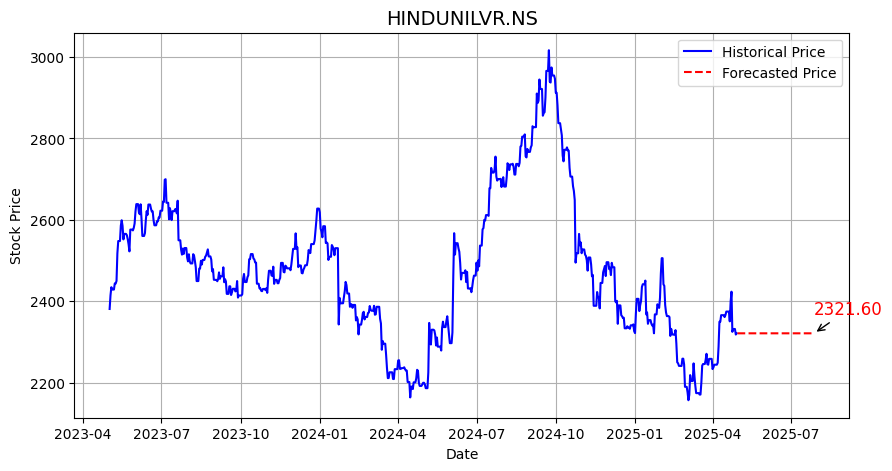

[*********************100%***********************]  1 of 1 completed


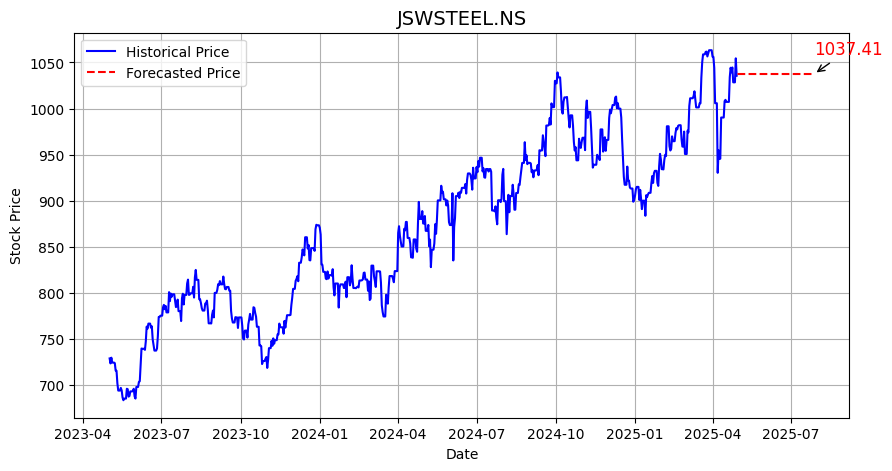

[*********************100%***********************]  1 of 1 completed


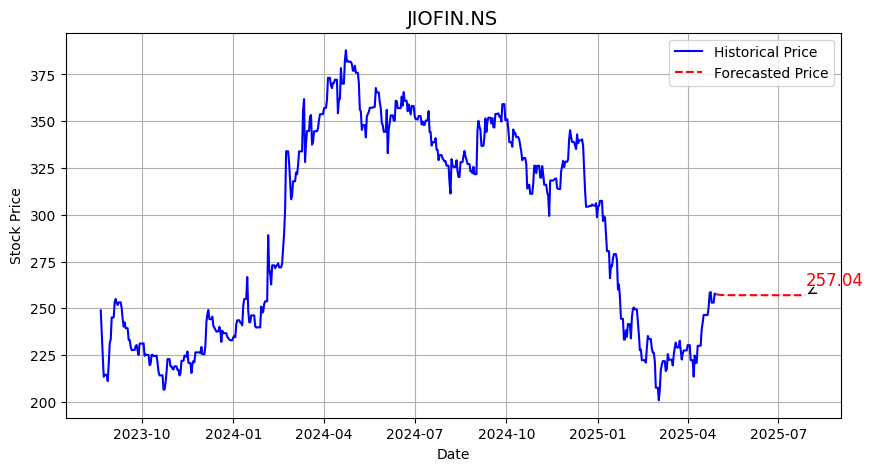

[*********************100%***********************]  1 of 1 completed


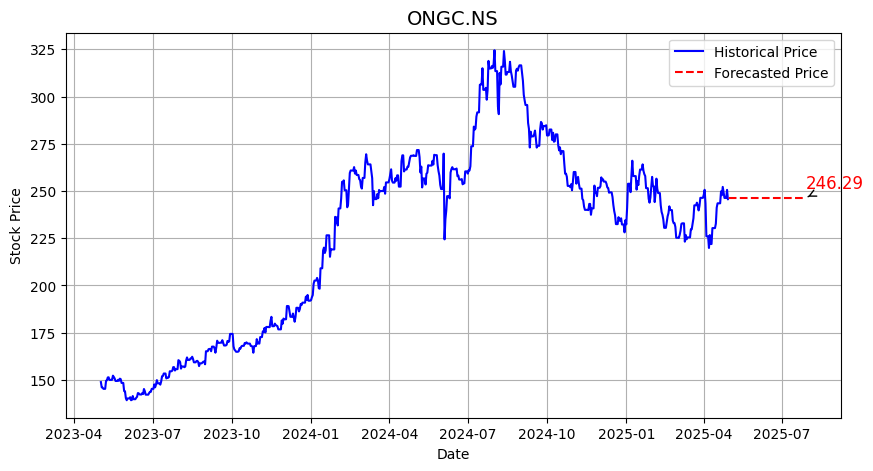

[*********************100%***********************]  1 of 1 completed


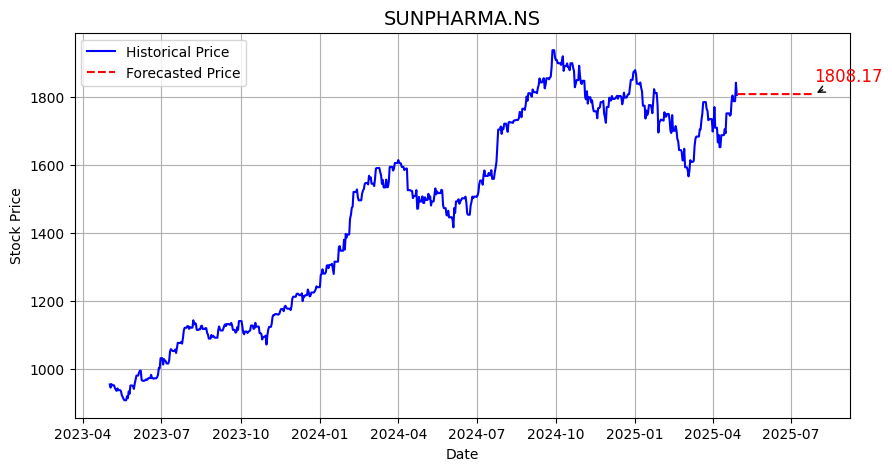

[*********************100%***********************]  1 of 1 completed


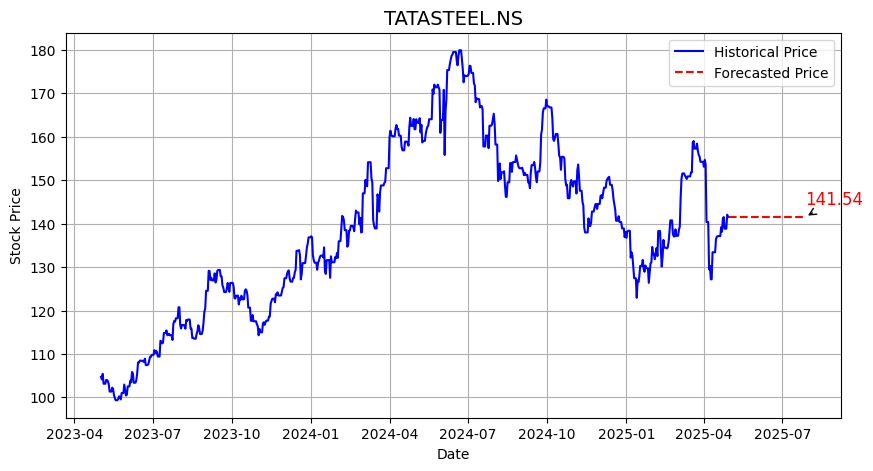

[*********************100%***********************]  1 of 1 completed


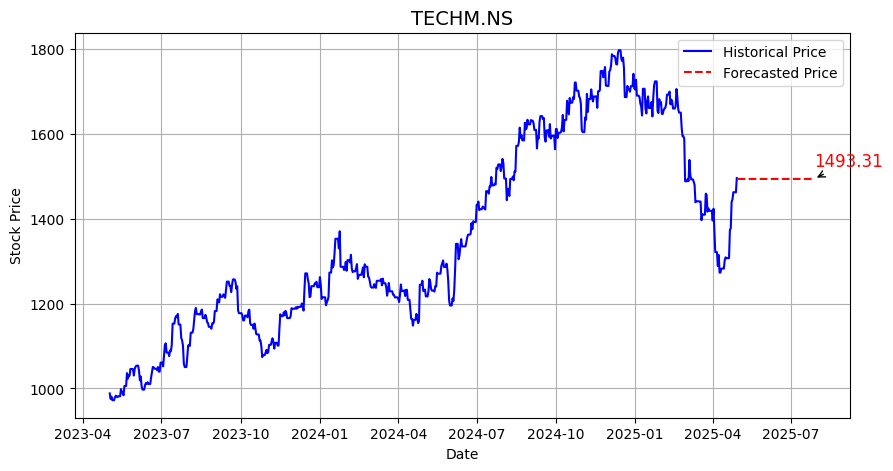

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


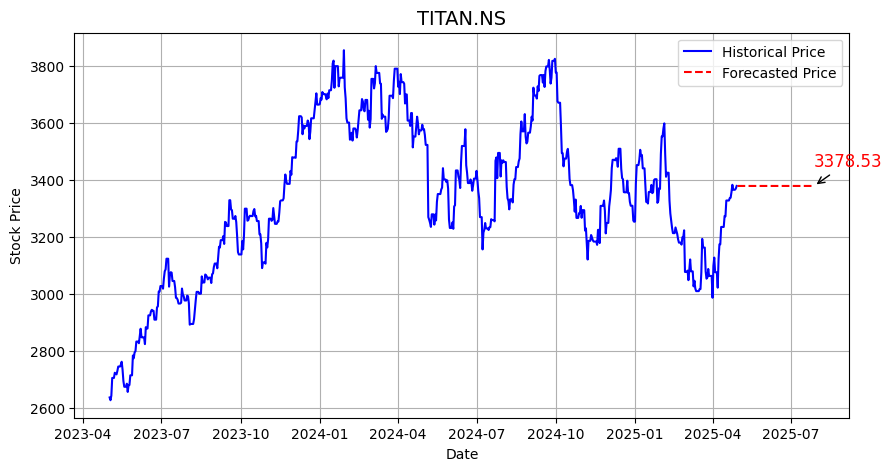

[*********************100%***********************]  1 of 1 completed


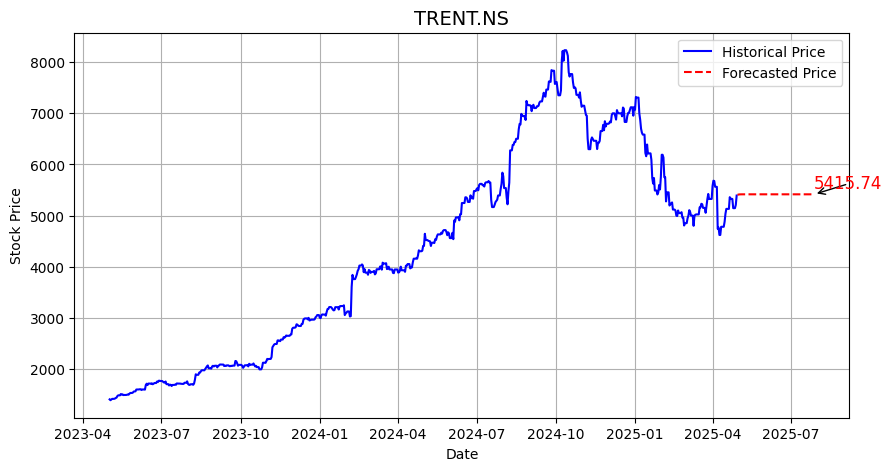

[*********************100%***********************]  1 of 1 completed


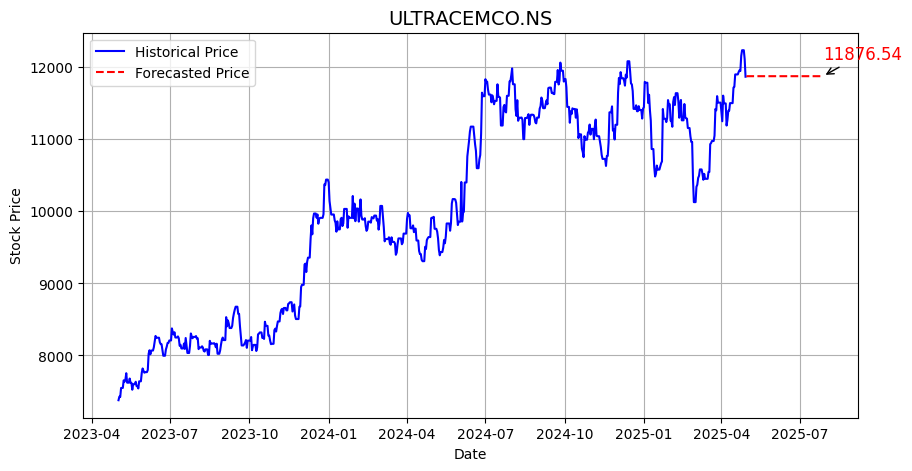

[*********************100%***********************]  1 of 1 completed


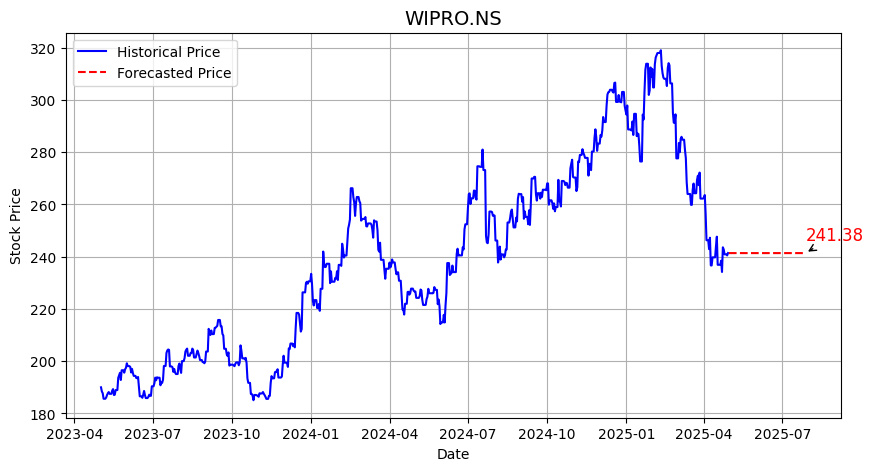

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load the Overvalued & Underperformed stocks file
file_path = "overvalued_stocks_final_performance.csv"
df = pd.read_csv(file_path)

# Filter stocks that are both Overvalued and Underperformed
selected_stocks = df[(df["Final Valuation"] == "Overvalued") & (df["CAPM Performance"] == "Underperformed")]["Symbol"]

# Forecasting period (next 3 months)
forecast_period = 90  # ~3 months

# Loop through each stock for ARIMA forecasting
for symbol in selected_stocks:
    try:
        # Fetch historical stock prices from Yahoo Finance (last 2 years for training)
        stock_data = yf.download(symbol, period="2y", interval="1d")["Close"].dropna()

        # Ensure the index is a proper DateTime index with a frequency
        stock_data.index = pd.to_datetime(stock_data.index)
        stock_data = stock_data.asfreq('D').ffill()  # Fill missing dates if any

        # Fit ARIMA model (Auto-order selection)
        model = ARIMA(stock_data, order=(1,1,1))  # (p,d,q) = (1,1,1) as a simple start
        model_fit = model.fit()

        # Forecast next 90 days
        forecast_index = pd.date_range(stock_data.index[-1], periods=forecast_period+1, freq='D')[1:]
        forecast = model_fit.forecast(steps=forecast_period)

        # Plot historical prices and forecasted prices
        plt.figure(figsize=(10,5))
        plt.plot(stock_data.index, stock_data, label="Historical Price", color="blue")
        plt.plot(forecast_index, forecast, label="Forecasted Price", color="red", linestyle="dashed")

        # Add text annotation for the forecasted price at the last point
        last_forecasted_price = forecast.iloc[-1]
        last_forecasted_date = forecast_index[-1]
        plt.annotate(f"{last_forecasted_price:.2f}",
                     xy=(last_forecasted_date, last_forecasted_price),
                     xytext=(last_forecasted_date, last_forecasted_price + (last_forecasted_price * 0.02)),
                     fontsize=12, color="red",
                     arrowprops=dict(facecolor='red', arrowstyle='->'))

        # Title with Stock Symbol
        plt.title(f"{symbol}", fontsize=14)
        plt.xlabel("Date")
        plt.ylabel("Stock Price")
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"Error processing {symbol}: {e}")

[*********************100%***********************]  1 of 1 completed


📢 The stocks that are both Overvalued and Underperformed: ['ADANIENT.NS', 'APOLLOHOSP.NS', 'COALINDIA.NS', 'EICHERMOT.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'JSWSTEEL.NS', 'JIOFIN.NS', 'ONGC.NS', 'SUNPHARMA.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'TRENT.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


📊 **Investment Results** (Final Value of ₹10,000 Investment per Stock):
📌 ADANIENT.NS: Invested ₹10,000 → Final Value: ₹9064.33
📌 APOLLOHOSP.NS: Invested ₹10,000 → Final Value: ₹8990.33
📌 COALINDIA.NS: Invested ₹10,000 → Final Value: ₹10457.47
📌 EICHERMOT.NS: Invested ₹10,000 → Final Value: ₹10946.51
📌 HINDALCO.NS: Invested ₹10,000 → Final Value: ₹11509.40
📌 HINDUNILVR.NS: Invested ₹10,000 → Final Value: ₹9727.62
📌 JSWSTEEL.NS: Invested ₹10,000 → Final Value: ₹11742.23
📌 JIOFIN.NS: Invested ₹10,000 → Final Value: ₹7472.82
📌 ONGC.NS: Invested ₹10,000 → Final Value: ₹10604.98
📌 SUNPHARMA.NS: Invested ₹10,000 → Final Value: ₹9233.87
📌 TATASTEEL.NS: Invested ₹10,000 → Final Value: ₹11279.80
📌 TECHM.NS: Invested ₹10,000 → Final Value: ₹8323.80
📌 TITAN.NS: Invested ₹10,000 → Final Value: ₹9414.54
📌 TRENT.NS: Invested ₹10,000 → Final Value: ₹7534.11
📌 ULTRACEMCO.NS: Invested ₹10,000 → Final Value: ₹10054.64
📌 WIPRO.NS: Invested ₹10,000 → Final Value: ₹8906.46


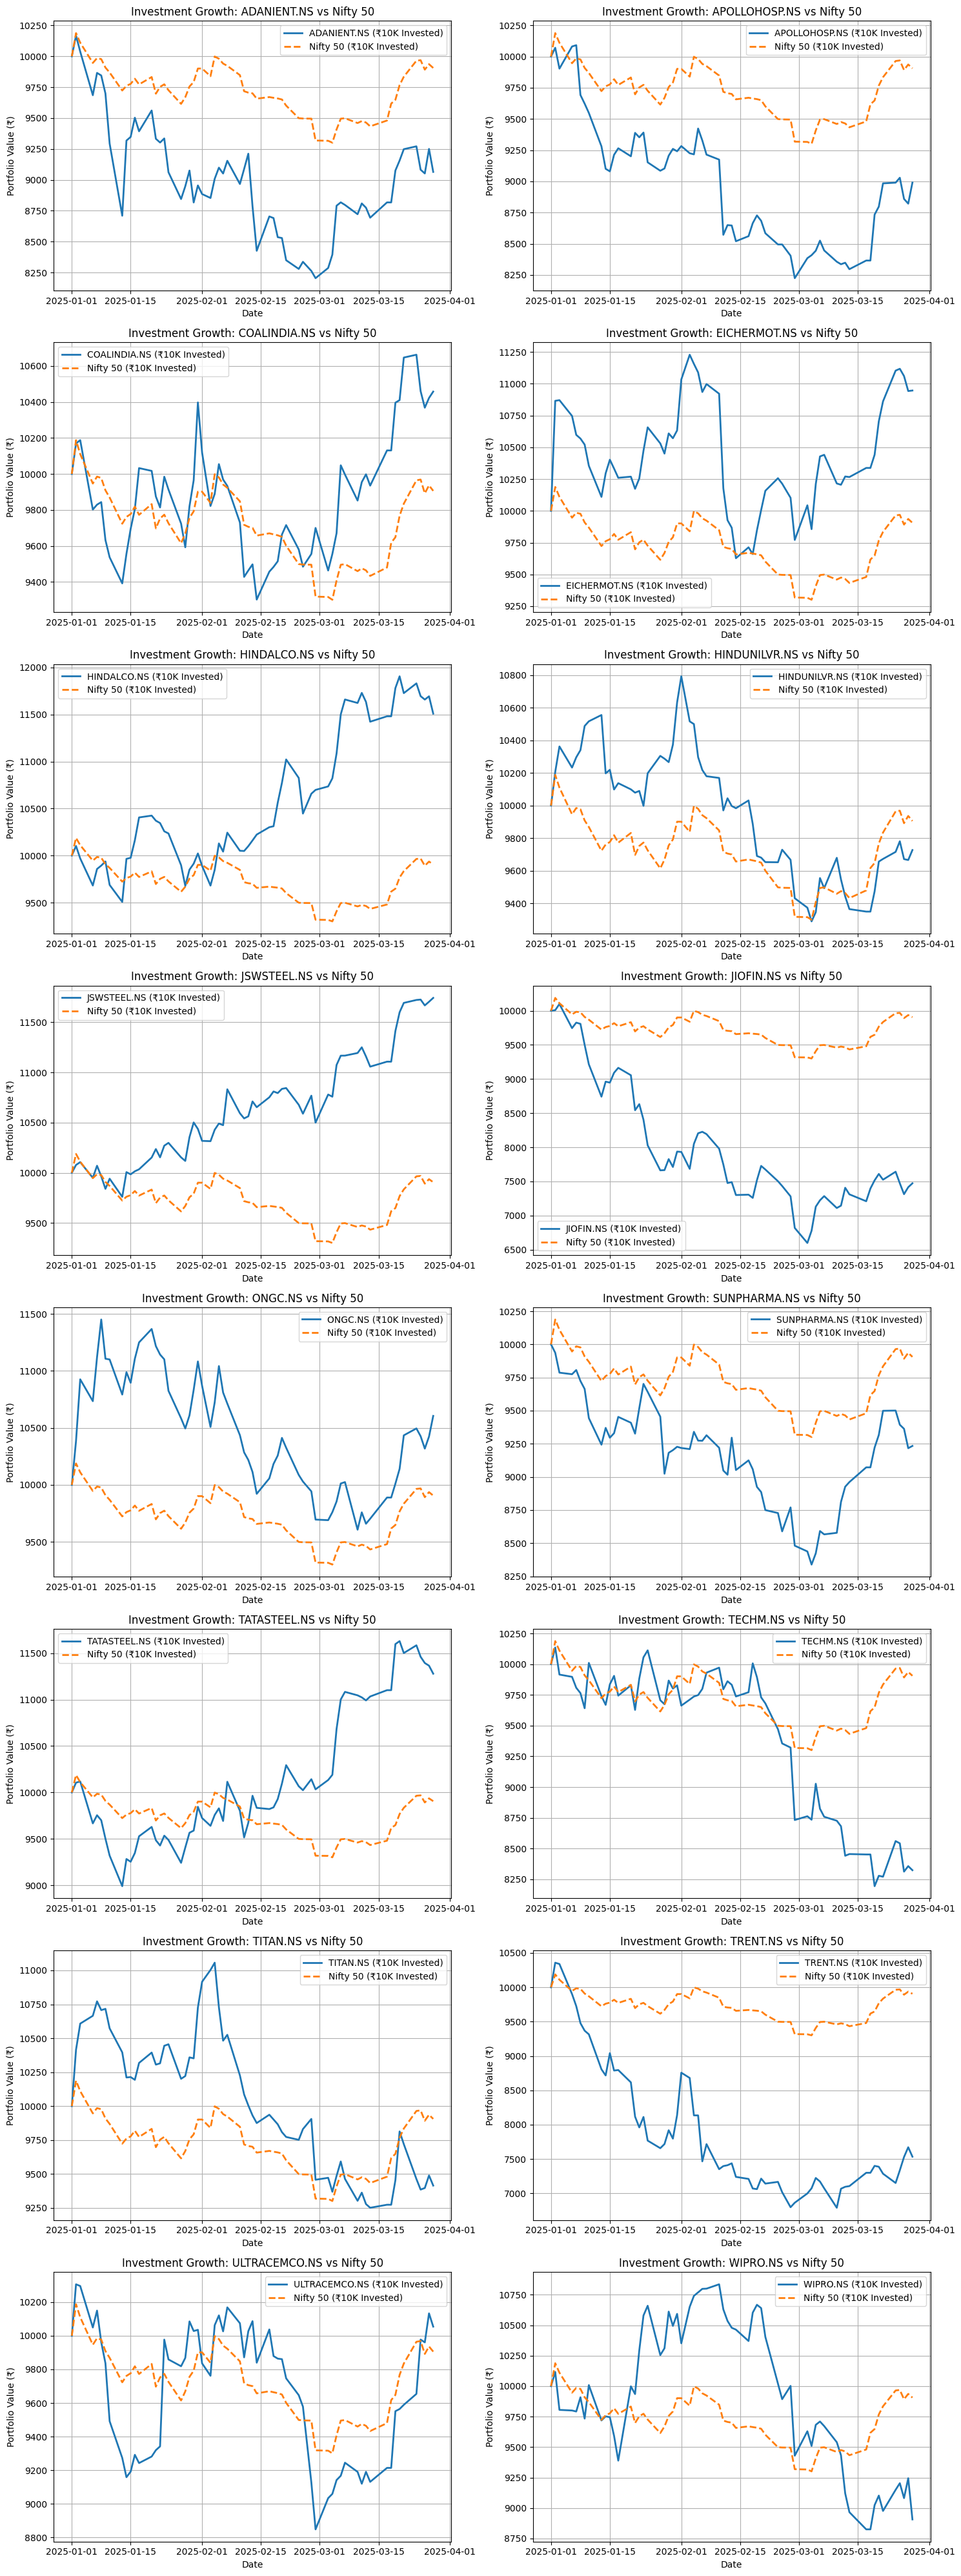

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Load the overvalued and underperforming stocks list
valuation_performance_file = "overvalued_stocks_final_performance.csv"
valuation_df = pd.read_csv(valuation_performance_file)

# Filter stocks that are both Overvalued & Underperformed
target_stocks = valuation_df[
    (valuation_df["Final Valuation"] == "Overvalued") &
    (valuation_df["CAPM Performance"] == "Underperformed")
]["Symbol"].tolist()

print(f"\n📢 The stocks that are both Overvalued and Underperformed: {target_stocks}\n")

# Fetch historical stock prices from Yahoo Finance
start_date = "2025-01-01"
end_date = "2025-04-01"

# Add Nifty 50 index symbol (^NSEI) to the stock list
all_symbols = target_stocks + ["^NSEI"]

# List to store DataFrames
stock_data = []

# Fetch each stock separately
for symbol in all_symbols:
    try:
        stock_df = yf.download(symbol, start=start_date, end=end_date)[["Close"]]  # ✅ Using "Close" price
        if not stock_df.empty:
            stock_df.columns = [symbol]  # ✅ Rename column to stock symbol
            stock_data.append(stock_df)  # ✅ Append DataFrame to list
        else:
            print(f"⚠️ No data found for {symbol}. Skipping...")
    except Exception as e:
        print(f"⚠️ Error fetching {symbol}: {e}")

# ✅ Ensure stock_data has valid time-series data before merging
if stock_data:
    stock_data = pd.concat(stock_data, axis=1)  # ✅ Correctly concatenate list of DataFrames
else:
    raise ValueError("❌ No valid stock data found. Check stock symbols or Yahoo Finance availability.")

# Drop completely missing stocks
available_stocks = [s for s in target_stocks if s in stock_data.columns]
missing_stocks = list(set(target_stocks) - set(available_stocks))

if missing_stocks:
    print(f"⚠️ Warning: The following stocks are missing from Yahoo Finance and will be excluded: {missing_stocks}")

# Ensure Nifty 50 data is available
if "^NSEI" not in stock_data.columns:
    raise ValueError("\n❌ Nifty 50 data missing! Cannot compare against Nifty.")
else:
    # Fill missing values
    stock_data.ffill(inplace=True)

    # ✅ Normalize based on ₹10,000 investment
    investment_amount = 10000
    investment_per_stock = investment_amount / stock_data.iloc[0]  # Number of shares bought for ₹10K
    investment_values = stock_data * investment_per_stock  # Portfolio value over time

    # 🔹 Store final investment results
    final_values = investment_values.iloc[-1]  # Last day's portfolio value

    print("\n📊 **Investment Results** (Final Value of ₹10,000 Investment per Stock):")
    print("=" * 60)
    for stock in available_stocks:
        start_price = stock_data[stock].iloc[0]
        end_value = final_values[stock]
        print(f"📌 {stock}: Invested ₹10,000 → Final Value: ₹{end_value:.2f}")

    # 📊 Create individual plots for each stock vs Nifty 50
    num_stocks = len(available_stocks)
    num_cols = 2  # 2 columns per row
    num_rows = (num_stocks // num_cols) + (num_stocks % num_cols > 0)  # Auto-calculate rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten axes to iterate easily

    for i, stock in enumerate(available_stocks):
        ax = axes[i]  # Select subplot
        ax.plot(investment_values.index, investment_values[stock], label=f"{stock} (₹10K Invested)", linewidth=2)
        ax.plot(investment_values.index, investment_values["^NSEI"], label="Nifty 50 (₹10K Invested)", linestyle="--", linewidth=2)

        ax.set_title(f"Investment Growth: {stock} vs Nifty 50")
        ax.set_xlabel("Date")
        ax.set_ylabel("Portfolio Value (₹)")
        ax.legend()
        ax.grid()

    # Hide empty subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📢 The stocks that are both Overvalued and Underperformed: ['ADANIENT.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'BEL.NS', 'COALINDIA.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HDFCBANK.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'JSWSTEEL.NS', 'JIOFIN.NS', 'NESTLEIND.NS', 'ONGC.NS', 'SBILIFE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'TRENT.NS', 'ULTRACEMCO.NS', 'ZOMATO.NS']




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

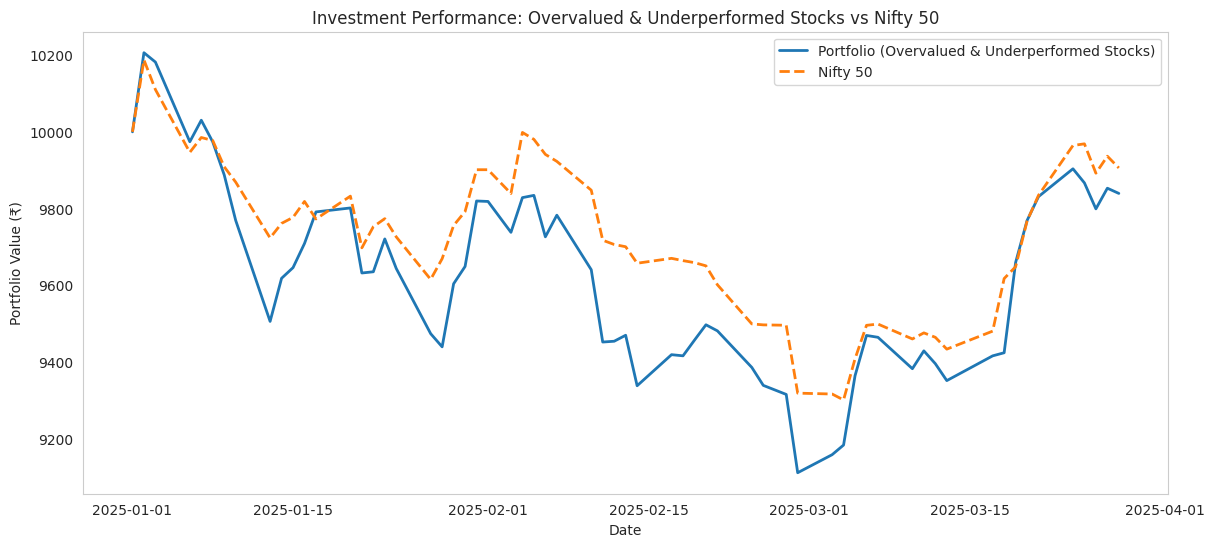


💰 Final Portfolio Value if ₹10,000 was invested in each:

📌 Overvalued & Underperformed Stocks: ₹9839.40
📌 Nifty 50: ₹9905.85


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Load the overvalued and underperforming stocks list
valuation_performance_file = "overvalued_stocks_final_performance.csv"
valuation_df = pd.read_csv(valuation_performance_file)

# Filter stocks that are both Overvalued & Underperformed
target_stocks = valuation_df[
    (valuation_df["Final Valuation"] == "Overvalued") &
    (valuation_df["CAPM Performance"] == "Underperformed")
]["Symbol"].tolist()

print(f"\n📢 The stocks that are both Overvalued and Underperformed: {target_stocks}\n")

# Fetch historical stock prices from Yahoo Finance
start_date = "2025-01-01"
end_date = "2025-04-01"

# Add Nifty 50 index symbol (^NSEI) to the stock list
all_symbols = target_stocks + ["^NSEI"]

# List to store DataFrames
stock_data = []

# Fetch each stock separately
for symbol in all_symbols:
    try:
        stock_df = yf.download(symbol, start=start_date, end=end_date)[["Close"]]  # ✅ Using "Close" price
        if not stock_df.empty:
            stock_df.columns = [symbol]  # ✅ Rename column to stock symbol
            stock_data.append(stock_df)  # ✅ Append DataFrame to list
        else:
            print(f"⚠️ No data found for {symbol}. Skipping...")
    except Exception as e:
        print(f"⚠️ Error fetching {symbol}: {e}")

# ✅ Ensure stock_data has valid time-series data before merging
if stock_data:
    stock_data = pd.concat(stock_data, axis=1)  # ✅ Correctly concatenate list of DataFrames
else:
    raise ValueError("❌ No valid stock data found. Check stock symbols or Yahoo Finance availability.")

# Drop completely missing stocks
available_stocks = [s for s in target_stocks if s in stock_data.columns]
missing_stocks = list(set(target_stocks) - set(available_stocks))

if missing_stocks:
    print(f"⚠️ Warning: The following stocks are missing from Yahoo Finance and will be excluded: {missing_stocks}")

# Ensure Nifty 50 data is available
if "^NSEI" not in stock_data.columns:
    raise ValueError("\n❌ Nifty 50 data missing! Cannot compare against Nifty.")
else:
    # Fill missing values
    stock_data.ffill(inplace=True)

    # Normalize stock prices (Index at 1)
    normalized_prices = stock_data / stock_data.iloc[0]

    # Investment Simulation: ₹10,000 equally distributed across all available stocks
    if available_stocks:  # Ensure there are stocks to invest in
        initial_investment = 10000
        allocation_per_stock = initial_investment / len(available_stocks)

        # Calculate portfolio performance
        portfolio_values = normalized_prices[available_stocks].dot([allocation_per_stock] * len(available_stocks))

        # Create DataFrame for comparison
        comparison_df = pd.DataFrame({
            "Overvalued & Underperformed Stocks": portfolio_values,
            "Nifty 50": normalized_prices["^NSEI"] * initial_investment
        })

        # Plot performance comparison
        plt.figure(figsize=(14, 6))
        plt.plot(comparison_df.index, comparison_df["Overvalued & Underperformed Stocks"], label="Portfolio (Overvalued & Underperformed Stocks)", linewidth=2)
        plt.plot(comparison_df.index, comparison_df["Nifty 50"], label="Nifty 50", linewidth=2, linestyle="--")

        plt.title("Investment Performance: Overvalued & Underperformed Stocks vs Nifty 50")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value (₹)")
        plt.legend()
        plt.grid()
        plt.show()

        # Print final portfolio values
        final_values = comparison_df.iloc[-1]
        print(f"\n💰 Final Portfolio Value if ₹10,000 was invested in each:\n")
        print(f"📌 Overvalued & Underperformed Stocks: ₹{final_values['Overvalued & Underperformed Stocks']:.2f}")
        print(f"📌 Nifty 50: ₹{final_values['Nifty 50']:.2f}")

    else:
        raise ValueError("\n❌ No valid stocks found for investment. Check stock symbols or Yahoo Finance data availability.")